In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/CIS5190_project/scraped_headlines.csv'
news_df = pd.read_csv(path)

In [4]:
news_df.head()

,title,outlet,label,url
0,jack carr recalls gen. eisenhower's d-day memo...,FoxNews,1,https://www.foxnews.com/lifestyle/jack-carrs-e...
1,"bruce willis, demi moore avoided doing one thi...",FoxNews,1,https://www.foxnews.com/entertainment/bruce-wi...
2,"blinken meets qatar pm, says israeli actions a...",FoxNews,1,https://www.foxnews.com/politics/blinken-meets...
3,emily blunt says her ‘toes curl’ when people t...,FoxNews,1,https://www.foxnews.com/entertainment/emily-bl...
4,"'the view' co-host, cnn commentator ana navarr...",FoxNews,1,https://www.foxnews.com/media/the-view-co-host...


In [5]:
news_df.isna().sum()

,0
title,0
outlet,0
label,0
url,1187


In [6]:
print("Dataset size:", news_df.shape)

Dataset size: (4972, 4)


In [7]:
with open("/content/drive/My Drive/CIS5190_project/custom_stopwords.txt", "r") as f:
    custom_stopwords = [line.strip() for line in f.readlines()]

In [8]:
def clean_text(text):
    text = text.lower()
    return text

In [9]:
news_df['clean_title'] = news_df['title'].apply(clean_text)

In [10]:
# ## Train-Test Split
X = news_df['clean_title']
y = news_df['label']  # 1 for FoxNews, 0 for NBC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Baseline
We use unigrams (ngram_range=(1,1)), default LogisticRegression, and a TF-IDF vectorizer with limited features. This provides a lower bound for performance.

In [11]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words=list(custom_stopwords), max_features=100, ngram_range=(1,1))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [12]:
# Baseline Logistic Regression Model
model = LogisticRegression(solver='liblinear', max_iter=100)
model.fit(X_train_vec, y_train)

LogisticRegression(solver='liblinear')

In [13]:
y_pred = model.predict(X_test_vec)
y_proba = model.predict_proba(X_test_vec)[:, 1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6663316582914572

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.64      0.66       495
           1       0.66      0.69      0.68       500

    accuracy                           0.67       995
   macro avg       0.67      0.67      0.67       995
weighted avg       0.67      0.67      0.67       995



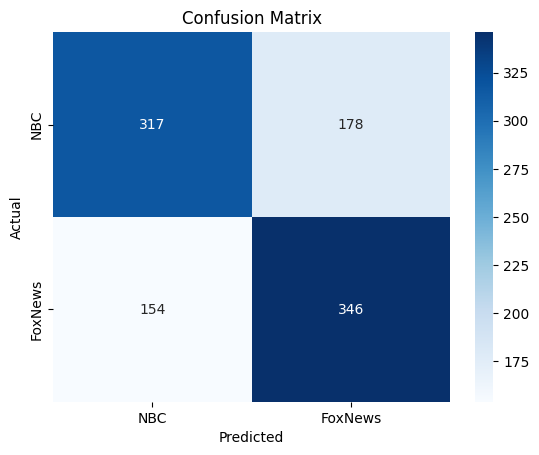

In [14]:
# confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NBC', 'FoxNews'], yticklabels=['NBC', 'FoxNews'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


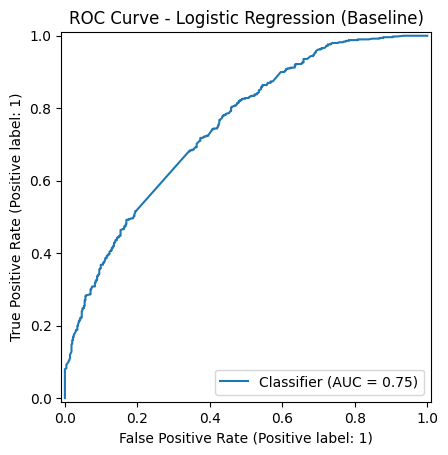

In [15]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Logistic Regression (Baseline)")
plt.show()

## GridSearchCV for Logistic Regression

Hyperparameter Optimization: We tune C, max_features, and ngram_range using GridSearchCV. This allows the model to generalize better and capture multi-word signals (bigrams)

In [16]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=custom_stopwords)),
    ('clf', LogisticRegression(max_iter=1000))
])

In [17]:
# Grid Search Parameters
param_grid = {
    'vectorizer__max_features': [2000, 3000, 5000],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.01, 0.1, 1, 10]
}

In [18]:
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words=['again',
                                                                    'being',
                                                                    'hers',
                                                                    'because',
                                                                    'off', 'o',
                                                                    "you'll",
                                                                    'nor', 'of',
                                                                    'he', 'are',
                                                                    'nbc',
                                                                    "wouldn't",
                                                                    'so', 'own',
                                                                    'this',
                                                                    'will',
                                                                    "weren't",
                                                                    'her',
                                                                    "wasn't",
                                                                    'same',
                                                                    'our',
                                                                    "he'll",
                                                                    'into',
                                                                    'which',
                                                                    'news',
                                                                    'breaking',
                                                                    "i'd",
                                                                    'them',
                                                                    'itself', ...])),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'vectorizer__max_features': [2000, 3000, 5000],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=2)

Best Parameters: {'clf__C': 1, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}
Accuracy (GridSearch): 0.7769
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78       495
           1       0.79      0.76      0.77       500

    accuracy                           0.78       995
   macro avg       0.78      0.78      0.78       995
weighted avg       0.78      0.78      0.78       995



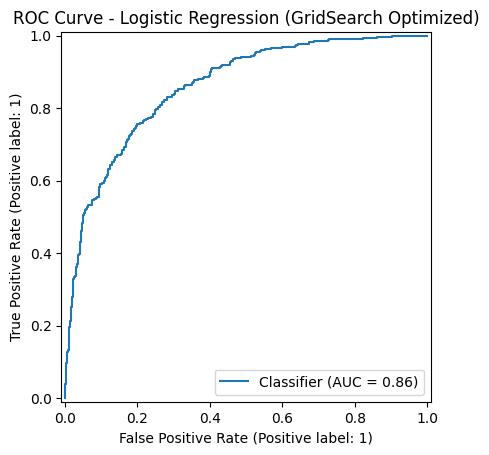

In [19]:
# Best model performance
print("Best Parameters:", grid.best_params_)

y_pred_grid = grid.predict(X_test)
y_proba_grid = grid.predict_proba(X_test)[:, 1]

print(f"Accuracy (GridSearch): {accuracy_score(y_test, y_pred_grid):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_grid))

RocCurveDisplay.from_predictions(y_test, y_proba_grid)
plt.title("ROC Curve - Logistic Regression (GridSearch Optimized)")
plt.show()

In [20]:
results = {
    "Model": ["Baseline Logistic", "Optimized Logistic (GridSearch)"],
    "Accuracy": [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_grid)],
    "ROC AUC": [roc_auc_score(y_test, y_proba), roc_auc_score(y_test, y_proba_grid)]
}

pd.DataFrame(results)

,Model,Accuracy,ROC AUC
0,Baseline Logistic,0.666332,0.748481
1,Optimized Logistic (GridSearch),0.776884,0.858994


## SentenceTransformers

Since we are dealing with headlines, other embeddings like Glove or Word2Vec will not be suitable as Headlines are very short (5–10 words) as these models loses word order + phrase-level nuance

So instead, trying out a lightweight alternative SentenceTransformers (all-MiniLM) which is semantic in nature and works well with short texts

To explore the semantic meaning beyond bag-of-words, we used the `all-MiniLM-L6-v2` model from Sentence Transformers to encode each headline into a 384-dimensional dense vector. This captures contextual meaning (e.g., synonyms, intent) even when exact words differ.

Then again using a Logistic Regression model on these vectors and used GridSearchCV to tune regularization. We can test if this semantic addition helps improve accuracy

In [21]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 978.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [22]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_vec = model.encode(X_train.tolist())
X_test_vec = model.encode(X_test.tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [23]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # normalize features before LR
    ('clf', LogisticRegression(max_iter=500))
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2'],
    'clf__solver': ['liblinear', 'saga']
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train_vec, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100],
                         'clf__penalty': ['l2'],
                         'clf__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

Best Parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Test Accuracy: 0.7326633165829146
ROC AUC: 0.8062545454545453

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74       495
           1       0.75      0.70      0.72       500

    accuracy                           0.73       995
   macro avg       0.73      0.73      0.73       995
weighted avg       0.73      0.73      0.73       995



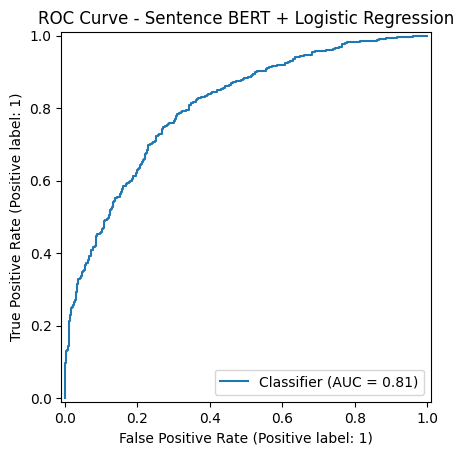

In [24]:
y_pred = grid.predict(X_test_vec)
y_proba = grid.predict_proba(X_test_vec)[:, 1]

print("Best Parameters:", grid.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Sentence BERT + Logistic Regression")
plt.show()

While semantic embeddings using traditional BERT and Sentence-BERT (MiniLM) offered a modern approach to capture contextual meaning, they underperformed compared to classic TF-IDF + Logistic Regression in our specific use case of short headlines. This is likely due to:

- extremely short length of headlines (average < 10 words), which limits contextual depth

- TF-IDF’s strength in sparse, high-dimensional text where editorial phrasing (bigrams) is more discriminative than deep semantics

Therefore, we proceeded with TF-IDF as primary feature extraction technique in downstream models like SVM, Naive Bayes.

